# Pose Detection and Matching with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses and similarity matching between those poses.

## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`
!mkdir openpose/images openpose/videos 

In [13]:
#!rm -r /content/openpose

In [18]:
!pip install pykalman
!pip install pygame

     |████████████████████████████████| 21.8 MB 99.3 MB/s 


# copy the deep sort data and utils files

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av '/content/drive/MyDrive/GDP/Openpose_deepsort/deep_sort' '/content/'
!cp -av '/content/drive/MyDrive/GDP/Openpose_deepsort/model_data' '/content/'
!cp -av '/content/drive/MyDrive/GDP/Openpose_deepsort/tools' '/content/'
!cp -av '/content/drive/MyDrive/GDP/Openpose_deepsort/CSA_data' '/content/'

In [1]:
# Import general libraries
# -*- coding: utf-8 -*-
import cv2
import sys
import time
import numpy as np
import pygame
import os 
import warnings
import glob
import pandas as pd
from google.colab.patches import cv2_imshow
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define Openpose directory destination
OpenposeDir = '/content/openpose/'

# Set Python Openpose Directory for python api (Important)
pyopenpose_dir = os.path.join(OpenposeDir,'build','python') # ex: '/content/openpose/build/python'
if pyopenpose_dir not in sys.path:
    sys.path.append(pyopenpose_dir)
from openpose import pyopenpose as op

from deep_sort.iou_matching import iou_cost
from deep_sort.kalman_filter import KalmanFilter
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker as DeepTracker
from deep_sort import nn_matching
from deep_sort import preprocessing
from deep_sort.linear_assignment import min_cost_matching
from deep_sort.detection import Detection as ddet
from tools import generate_detections as gdet
from utils import Updated_keypoint, pose2box, updated_boxes, calc_motion_efficiency, cal_S
import matplotlib.pyplot as plt
from collections import defaultdict
import Constants
import datetime

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#@title
import numpy as np
from scipy.signal import savgol_filter

def smooth_curve(path):
    x = []
    y = []

    n = 0
    for i, j in path:
        if n%4 == 0:
            x.append(i)
            y.append(j)
            n +=1

    x = np.array(x)
    y = np.array(y)

    t = len(x)-1
    c = int(t)-3 if t%2 == 0 else int(t)-2
    yhat = savgol_filter(y, c, t)

    curve = np.column_stack((x.astype(np.int32), yhat.astype(np.int32)))
    return curve



In [28]:
# Define standard thresholds for calculations

sm_p = Constants.sm_p
T_mh = Constants.T_mh
T_ml = Constants.T_ml
sigma_m = Constants.sigma_m

In [32]:
dataset['pred_label'] = [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import argparse

def parse_args():
    """Parse command line arguments.
    """
    parser = argparse.ArgumentParser(description="Re-ID feature extractor")
    parser.add_argument(
        "--model",
        default="resources/networks/mars-small128.pb",
        help="Path to freezed inference graph protobuf.")
    parser.add_argument(
        "--mot_dir", help="Path to MOTChallenge directory (train or test)",
        required=True)
    parser.add_argument(
        "--detection_dir", help="Path to custom detections. Defaults to "
        "standard MOT detections Directory structure should be the default "
        "MOTChallenge structure: [sequence]/det/det.txt", default=None)
    parser.add_argument(
        "--output_dir", help="Output directory. Will be created if it does not"
        " exist.", default="detections")

    return parser.parse_args()


def main():
    args = parse_args()


if __name__ == "__main__":
    main()

In [ ]:

cap = cv2.VideoCapture('/content/CSA_data/enacted_drunk/10_drunk.mp4')

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#from openpose import *
params = dict()
params["model_folder"] = os.path.join(OpenposeDir,'models')
params["net_resolution"] = "-1x320"

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

max_cosine_distance = Constants.max_cosine_distance
nn_budget = Constants.nn_budget
nms_max_overlap = Constants.nms_max_overlap
max_age = Constants.max_age
n_init = Constants.n_init

model_filename = '/content/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", \
                                                max_cosine_distance, \
                                                nn_budget)
tracker = DeepTracker(metric)

centroid_dict = defaultdict(list)
object_id_list = []

sm_initial = 0
starting_line = Constants.starting_line

frames = []
while True:
    ret, frame = cap.read()

    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        frame = frame[210:]
        height, width, layers = frame.shape

        datum = op.Datum()
        input_image = frame # Change Image Here
        datum.cvInputData = input_image
        opWrapper.emplaceAndPop(op.VectorDatum([datum]))
        keypoints = np.array(datum.poseKeypoints)
        #Add openpose results to my current frame
        keypoints = Updated_keypoint(keypoints)
        
        try:
            # Doesn't use keypoint confidence
            poses = keypoints[:,:,:2]
            # Get containing box for each seen body
            boxes = pose2box(poses)
            boxes = updated_boxes(boxes, starting_line, height)
            boxes_xywh = [[x1,y1,x2-x1,y2-y1] for [x1,y1,x2,y2] in boxes]
            features = encoder(input_image, boxes_xywh)

            nonempty = lambda xywh: xywh[2] != 0 and xywh[3] != 0
            detections = [Detection(bbox, 1.0, feature, pose)\
                        for bbox, feature, pose in zip(boxes_xywh, features, poses)\
                        if nonempty(bbox)]

            # Run non-maxima suppression.
            boxes_det = np.array([d.tlwh for d in detections])
            scores = np.array([d.confidence for d in detections])
            indices = preprocessing.non_max_suppression(boxes_det, \
                                                        nms_max_overlap, scores)
            detections = [detections[i] for i in indices]

            # Using Deep SORT to track the actual frame
            tracker.predict()
            tracker.update(input_image, detections)
            
            for track in tracker.tracks:
                bbox = track.to_tlbr()
                objectID = '{}'.format(track.track_id)
                #print(objectID)
                x1, y1, x2, y2 = bbox

                x1 = int(x1)
                y1 = int(y1)
                x2 = int(x2)
                y2 = int(y2)

                cX = int((x1 + x2) / 2.0)
                cY = int(y2)
                drunk = False
                if (y2 < (height * 90/100) \
                    and  cY > (height * 10/100) \
                    and x1 > 30 and x2 < width - 30):
                    centroid_dict[objectID].append((cX, cY))
                    #print(len(centroid_dict[objectID]))
                    if objectID not in object_id_list:
                        object_id_list.append(objectID)
                        start_pt = (cX, cY)
                        end_pt = (cX, cY)
                        cv2.line(input_image, start_pt, end_pt, (0, 255, 0), 2)
                    else:
                        path = centroid_dict[objectID]
                        cal_path = []
                        for i in range(0, len(path), 7):
                            cal_path.append(path[i])
                        #print(cal_path)

                        if len(cal_path) > 2 and len(cal_path) < 20:
                            #print(len(centroid_dict[objectID]))
                            cal_path = np.array(cal_path, np.int32)
                            cv2.polylines(input_image, [cal_path.reshape((-1, 1, 2))],\
                                        False, (0,255,255), 3)

                        elif  len(cal_path) >= 20:
                            #print(len(centroid_dict[objectID]))
                            cal_path = np.array(cal_path[-20:-1], np.int32)
                            cv2.polylines(input_image, [cal_path.reshape((-1, 1, 2))], \
                                        False, (0,255,255), 3)

                        
                        cal_path_sm = []
                        for i in range(0, len(path), 3):
                            cal_path_sm.append(path[i])
                        if len(cal_path_sm) > 7:
                            motion_efficiency = calc_motion_efficiency(cal_path_sm[-8:-1])
                            lambd_pt = 1 - motion_efficiency
                            #print(cal_path)

                            if  objectID not in sm_p.keys():
                                sm = cal_S(lambd_pt, T_mh, T_ml, sigma_m, sm_initial)
                                sm_p[objectID] = sm
                                drunk = True if sm_p[objectID] > 16 else False
                                #print(objectID, '---------',lambd_pt, sm, sm_p[objectID])
                                
                            else:
                                sm = cal_S(lambd_pt, T_mh, T_ml, sigma_m, sm_p[objectID])
                                sm_p[objectID] = sm
                                drunk = True if sm_p[objectID] > 16 else False
                                #print(objectID, '---------',lambd_pt, sm, sm_p[objectID])

                if drunk:
                    color = (255,0,0)
                    cv2.rectangle(input_image, (x1-40, y1), (x1-10, y2), color, -1)
                    text = 'Drunk'
                    cv2.putText(input_image, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, color, 2)
                        
                #else:
                    # color = (255,255,0)
                    # cv2.rectangle(input_image, (x1-40, y1), (x1-10, y2), color, -1)
                    # text = 'Normal'
                    # cv2.putText(input_image, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 4, (0, 0, 255), 4)
        
            frames.append(input_image)
            plt.imshow(input_image)
            plt.show()
            
        except:
            pass

    else:
        # Break when finished
        print("Frame Extracting Finished")
        break


cap.release()

height, width, layers = frames[0].shape
size = (width,height)

# Define the codec and create VideoWriter object
name = video + '.avi'
# Write Video Frame
out = cv2.VideoWriter(name ,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frames)):
    out.write(frames[i])

# When everything done, release the video capture and video write objects
out.release()

In [26]:
import seaborn as sns
from sklearn import metrics

def bin_metrics(y_test, y_pred):
    
    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    print('-----------------------------------------------------------')
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, y_pred))

    print('\n-----------------------------------------------------------\n')
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True)
    plt.show()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr,  label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


-----------------------------------------------------------
Confusion Matrix:
[[15  0]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


-----------------------------------------------------------



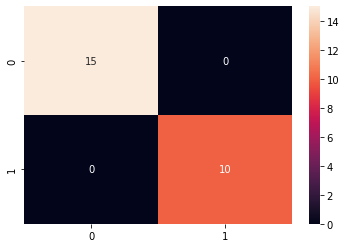

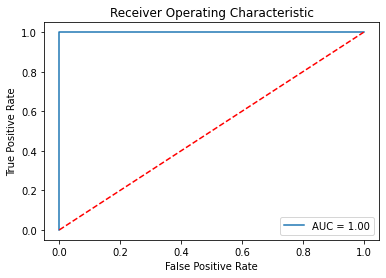

In [27]:
bin_metrics(data.label, data.label)